# Continuous Estimation Results

This notebooks is used primarily to visualize the outputs of the previous notebooks, and to reproduce the figures seen in the thesis.

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from comms import *

max_seq = signal.max_len_seq(7)[0][:64]

In [2]:
snr_range = np.arange(-15,11)
seq_lengths = [16, 32, 64]
num_examples = 8192
num_models = 5

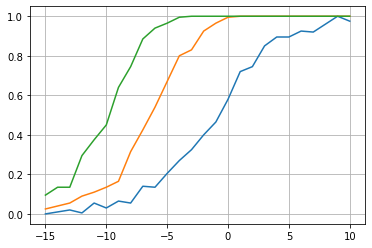

In [3]:
baselines = torch.load('baseline/mtl_fs_snr_baselines.pt')['baselines']

for seq_length in seq_lengths:
    plt.plot(snr_range, baselines[seq_length])
plt.grid()

In [4]:
all_loss_ratios = []
for i in range(1,10):
    models = []

    fs_weight = 1
    snr_weight = round(1 - i*0.1, 1)
    
    loss_ratios = (fs_weight, snr_weight)
    
    all_loss_ratios.append(loss_ratios)
all_loss_ratios

[(1, 0.9),
 (1, 0.8),
 (1, 0.7),
 (1, 0.6),
 (1, 0.5),
 (1, 0.4),
 (1, 0.3),
 (1, 0.2),
 (1, 0.1)]

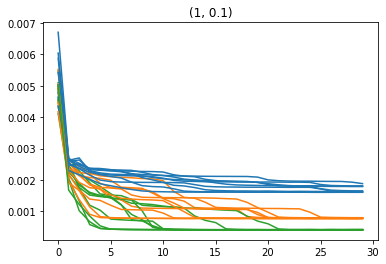

In [5]:
for loss_ratios in all_loss_ratios:
#     plt.figure()
    for i, seq_length in enumerate(seq_lengths):
        models = torch.load(f'models/continuous/mtl_fs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{num_examples}_{seq_length}.pt')
        plt.plot(np.mean([model['fs_losses'] for model in models],axis=0), f'C{i}')
#         plt.plot(np.mean([model['val_losses'] for model in models],axis=0), f'C{i}--')
    plt.title(f'{loss_ratios}')
#         plt.plot(np.mean([model['snr_losses'] for model in models],axis=0), f'C{i}')

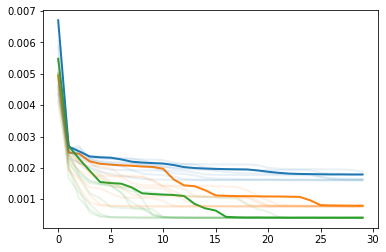

In [6]:
# temp_loss_ratios = [(1,0.9), (1, 0.5)]
alpha = 1
for j, loss_ratios in enumerate(all_loss_ratios):
#     plt.figure()
    for i, seq_length in enumerate(seq_lengths):
        models = torch.load(f'models/continuous/mtl_fs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{num_examples}_{seq_length}.pt')
        if j>0:
            alpha=0.1
        plt.plot(np.mean([model['fs_losses'] for model in models],axis=0), f'C{i}', linewidth=2, alpha=alpha)

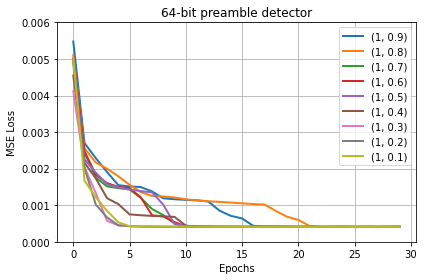

In [7]:
seq_length=64
for j, loss_ratios in enumerate(all_loss_ratios):
    models = torch.load(f'models/continuous/mtl_fs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{num_examples}_{seq_length}.pt')
    if j>0:
        alpha=0.1
    plt.plot(np.mean([model['fs_losses'] for model in models],axis=0), linewidth=2, alpha=1)
plt.legend(all_loss_ratios)
plt.xlabel('Epochs'); plt.ylabel('MSE Loss')
plt.title(f'{seq_length}-bit preamble detector')
plt.grid()
plt.ylim([0, 0.006])
plt.tight_layout()
# plt.savefig(f"figures/fs_snr_mtl_training_losses_{seq_length}.png", dpi=300, bbox_inches='tight')

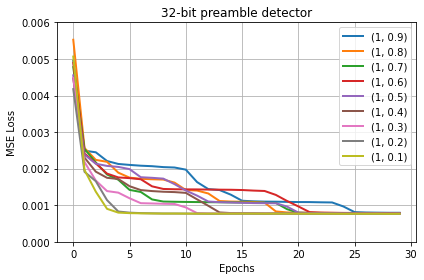

In [8]:
seq_length=32
for j, loss_ratios in enumerate(all_loss_ratios):
    models = torch.load(f'models/continuous/mtl_fs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{num_examples}_{seq_length}.pt')
    if j>0:
        alpha=0.1
    plt.plot(np.mean([model['fs_losses'] for model in models],axis=0), linewidth=2, alpha=1)
plt.legend(all_loss_ratios)
plt.xlabel('Epochs'); plt.ylabel('MSE Loss')
plt.title(f'{seq_length}-bit preamble detector')
plt.grid()
plt.ylim([0, 0.006])
plt.tight_layout()
# plt.savefig(f"figures/fs_snr_mtl_training_losses_{seq_length}.png", dpi=300, bbox_inches='tight')

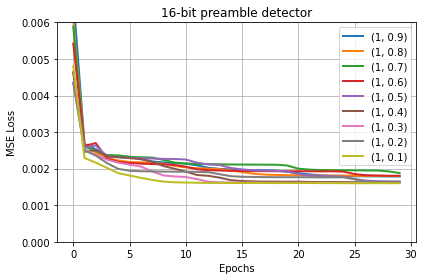

In [9]:
seq_length=16
for j, loss_ratios in enumerate(all_loss_ratios):
    models = torch.load(f'models/continuous/mtl_fs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{num_examples}_{seq_length}.pt')
    if j>0:
        alpha=0.1
    plt.plot(np.mean([model['fs_losses'] for model in models],axis=0), linewidth=2, alpha=1)
plt.legend(all_loss_ratios)
plt.xlabel('Epochs'); plt.ylabel('MSE Loss')
plt.title(f'{seq_length}-bit preamble detector')
plt.grid()
plt.ylim([0, 0.006])
plt.tight_layout()
# plt.savefig(f"figures/fs_snr_mtl_training_losses_{seq_length}.png", dpi=300, bbox_inches='tight')

In [10]:
class preamble_detector_mtl(nn.Module):
    def __init__(self):
        super(preamble_detector_mtl, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, (2,55), 1, padding=(0,27))
        self.conv2 = nn.Conv2d(32, 32, (1,55), 1, padding=(0,27))
        
        self.conv3 = nn.Conv2d(32,1,1,1)
        
        self.snr_estimator = nn.Conv2d(32,1,1,1)

    def forward(self, x):

        # First conv layer, correlation
        x = F.relu(self.conv1(x))
        
        # 2nd conv layer, non-linearities and cleanup
        x = F.relu(self.conv2(x))
        
        # SNR estimation head
        snr = self.snr_estimator(x)
        snr = snr.squeeze()
        
        # Final linear / combining layer
        x = self.conv3(x)
        
        # Output only 1 dimension
        x = x.squeeze()

        return x, snr
    
class preamble_detector(nn.Module):
    def __init__(self):
        super(preamble_detector, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, (2,55), 1, padding=(0,27))
        self.conv2 = nn.Conv2d(32, 32, (1,55), 1, padding=(0,27))
        
        self.conv3 = nn.Conv2d(32,1,1,1)
        
    def forward(self, x):

        # First conv layer, correlation
        x = F.relu(self.conv1(x))
        
        # 2nd conv layer, non-linearities and cleanup
        x = F.relu(self.conv2(x))
        
        # Final linear / combining layer
        x = self.conv3(x)
        
        # Output only 1 dimension
        x = x.squeeze()

        return x

In [11]:
def find_best_worst(results):
    best_acc = 0
    worst_acc = 100
    for idx, result in enumerate(results):
        mean_acc = np.mean(np.array(result['accs']))
        if mean_acc < worst_acc:
            worst_acc = mean_acc
            worst_idx = idx
        if mean_acc > best_acc:
            best_acc = mean_acc
            best_idx = idx
    return best_idx, worst_idx

def calc_stats(path='results/amc_0.1_0.9.pt'):
    results = torch.load(path)
    best_idx, worst_idx = find_best_worst(results)
    # plt.plot(results[0]['cfos'], 1-np.array(ders_per_cfo_5))
    for idx, result in enumerate(results):
        if idx == best_idx:
            mean_fcn_best = np.mean(np.array(result['accs']))
        if idx == worst_idx:
            mean_fcn_worst = np.mean(np.array(result['accs']))
    mean_fcn = np.mean(np.array([result['accs'] for result in results]).mean(axis=0))
    
    return mean_fcn_best, mean_fcn, mean_fcn_worst

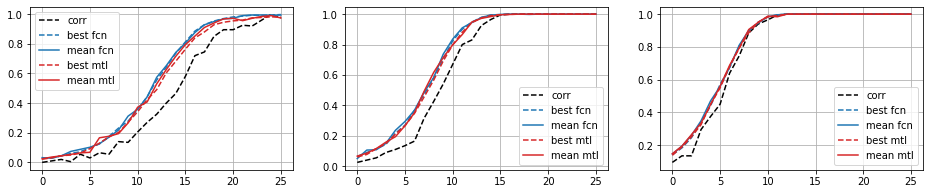

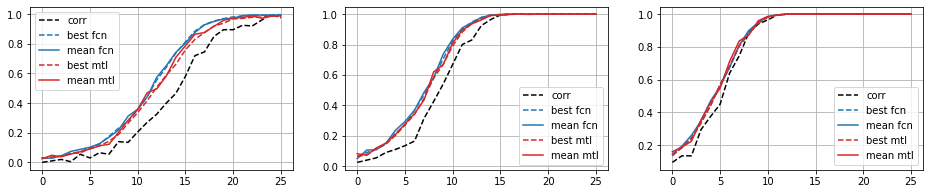

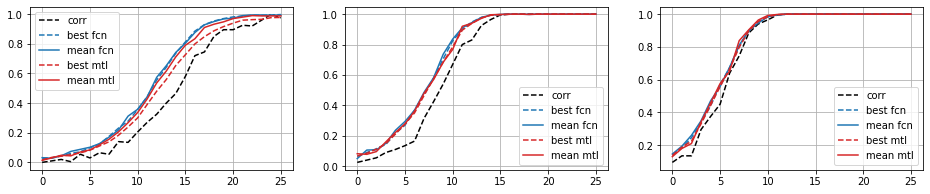

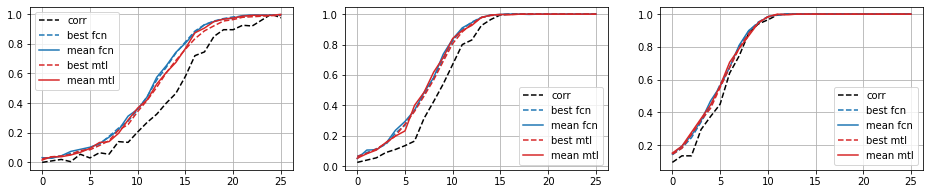

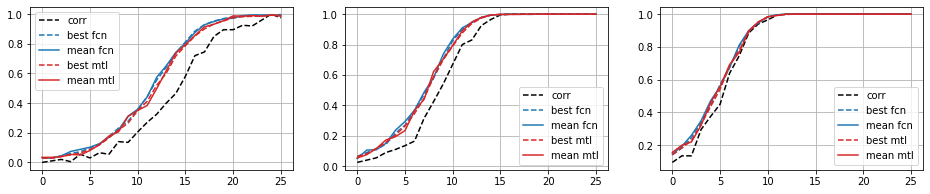

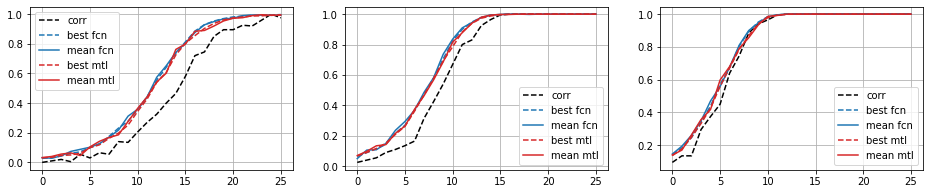

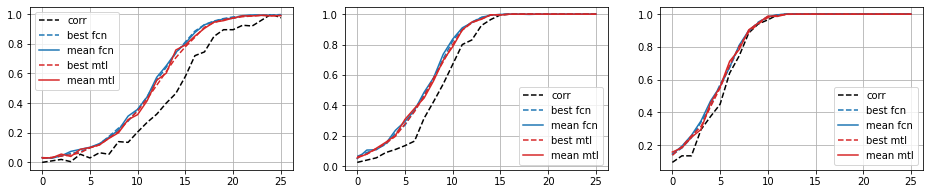

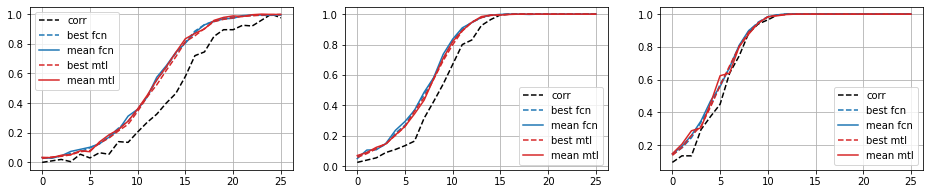

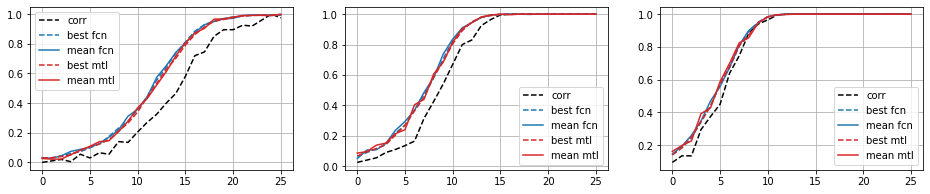

In [12]:
for loss_ratios in all_loss_ratios:
    fig, ax = plt.subplots(1,3, figsize=(16,3))

    for i, seq_length in enumerate(seq_lengths):
        ax[i].plot(baselines[seq_length], 'k--')
        
        results = torch.load(f'results/continuous/fs_{num_examples}_{seq_length}.pt')
        best_idx, worst_idx = find_best_worst(results)
        ax[i].plot(np.mean([result['accs'] for result in results], axis=0), f'C0--')
        ax[i].plot(results[best_idx]['accs'], f'C0')
        ax[i].grid()
        
        results = torch.load(f'results/continuous/mtl_fs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{num_examples}_{seq_length}.pt')
        best_idx, worst_idx = find_best_worst(results)
        ax[i].plot(np.mean([result['accs'] for result in results], axis=0), f'C3--')
        ax[i].plot(results[best_idx]['accs'], f'C3')
        
        
        
        ax[i].legend(['corr', 'best fcn', 'mean fcn', 'best mtl', 'mean mtl'])

7
8
8


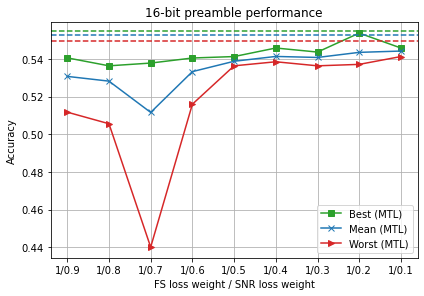

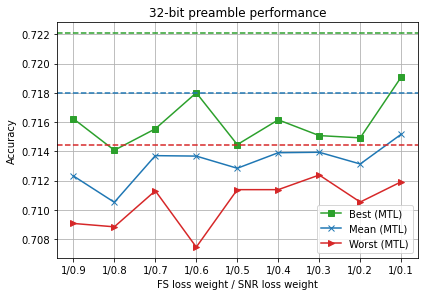

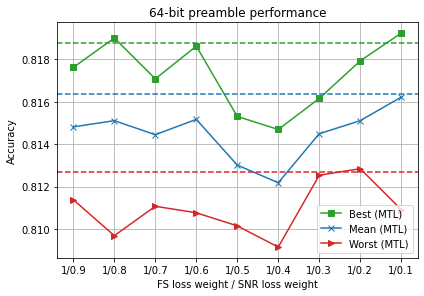

In [13]:
for seq_length in seq_lengths:
    bests, means, worsts = [], [], []

    for loss_ratios in all_loss_ratios:
        best, mean, worst = calc_stats(f'results/continuous/mtl_fs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{num_examples}_{seq_length}.pt')
        bests.append(best)
        means.append(mean)
        worsts.append(worst)
    print(np.argmax(bests))
#     print(np.argmax(means))

    baseline_best, baseline_mean, baseline_worst = \
    calc_stats(path=f"results/continuous/fs_{num_examples}_{seq_length}.pt")

    legend = [f'{loss_ratios[0]}/{loss_ratios[1]}' for loss_ratios in all_loss_ratios]

    plt.figure()
    plt.plot(np.array(bests), '-s', color='C2')
    plt.plot(np.array(means), '-x', color='C0')
    plt.plot(np.array(worsts), '->', color='C3')
    plt.axhline(y=baseline_best, color='C2', linestyle='--')
    plt.axhline(y=baseline_mean, color='C0', linestyle='--')
    plt.axhline(y=baseline_worst, color='C3', linestyle='--')
#     plt.legend(['Best (MTL)', 'Mean (MTL)', 'Worst (MTL)', 'Best (baseline)', 'Mean (baseline)', 'Worst (baseline)'], loc='lower right')
    plt.legend(['Best (MTL)', 'Mean (MTL)', 'Worst (MTL)'], loc='lower right')
    plt.xticks(np.arange(len(all_loss_ratios)), legend)
    plt.xlabel('FS loss weight / SNR loss weight'); plt.ylabel('Accuracy')
    plt.grid()
    # plt.ylim([0.75, 0.8])
    plt.tight_layout()
    plt.title(f'{seq_length}-bit preamble performance')
#     plt.savefig(f'figures/fs_snr_mtl_loss_weighting_results_{seq_length}.png', dpi=300, bbox_inches='tight')

In [14]:
best_loss_ratios = [(1, 0.2), (1, 0.1), (1,0.1)]

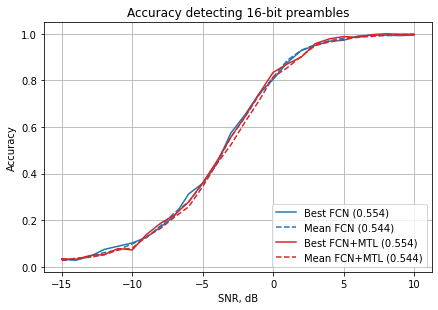

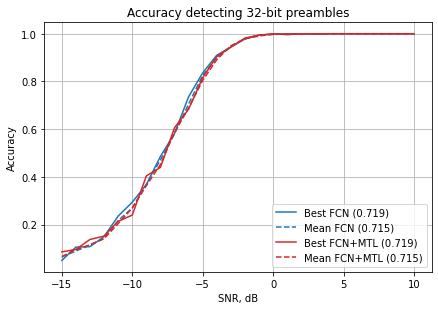

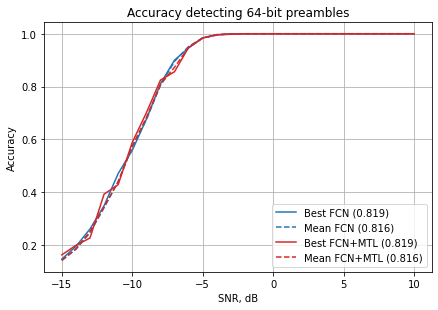

In [15]:
for seq_length, loss_ratios in zip(seq_lengths, best_loss_ratios):
    plt.figure()
#     plt.plot(snr_range, baselines[seq_length], 'k--')

    results = torch.load(f'results/continuous/fs_{num_examples}_{seq_length}.pt')
    best_idx, worst_idx = find_best_worst(results)
    plt.plot(snr_range, results[best_idx]['accs'], f'C0')
    plt.plot(snr_range, np.mean([result['accs'] for result in results], axis=0), f'C0--')
    plt.grid()

    results = torch.load(f'results/continuous/mtl_fs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{num_examples}_{seq_length}.pt')
    best_idx, worst_idx = find_best_worst(results)
    plt.plot(snr_range, results[best_idx]['accs'], f'C3')
    plt.plot(snr_range, np.mean([result['accs'] for result in results], axis=0), f'C3--')

    
    # calc mean accs
    fcn_acc = round(np.mean([result['accs'] for result in results]), 3)
    fcn_best_acc = round(np.mean(results[best_idx]['accs']), 3)
    
    mtl_acc = round(np.mean([result['accs'] for result in results]), 3)
    mtl_best_acc = round(np.mean(results[best_idx]['accs']), 3)
    
    plt.legend([f'Best FCN ({fcn_best_acc})', f'Mean FCN ({fcn_acc})', 
                f'Best FCN+MTL ({mtl_best_acc})', f'Mean FCN+MTL ({mtl_acc})'], loc='lower right')
    plt.tight_layout()
    
    plt.xlabel('SNR, dB')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy detecting {seq_length}-bit preambles')
#     plt.savefig(f'figures/fs_snr_mtl_loss_weighting_der_results_{seq_length}.png', dpi=300, bbox_inches='tight')

In [17]:
models = torch.load(f'results/continuous/mtl_fs_snr_1_0.1_{num_examples}_64.pt')

In [23]:
detector = preamble_detector_mtl()
detector.load_state_dict(models[4]['model']['weights'])

<All keys matched successfully>

In [24]:
preamble = np.where(max_seq[:seq_length] < 1, -1+0j, 1+0j)

In [25]:
# make one frame of data with preamble attached with random time offset
def create_frame(preamble_seq, payload=128, signal_length=200, offset=40):
    waveform = np.random.randint(0,2,signal_length)
    waveform[offset:offset+len(preamble_seq)] = preamble_seq
    waveform = np.where(waveform < 1, -1+0j, 1+0j)
    
    return waveform

In [26]:
detector.cpu()

# Create new frame with a random tau
payload = 128
signal_length = 1000
tau = 100

add_phase_offset = False
carrier_offset = None
add_channel = False

# snr = 10
normalize = True

sample_rate = 1e6

my_frame = create_frame(max_seq[:seq_length], payload=payload, signal_length=signal_length, offset=tau)

if add_phase_offset:
    ph = np.random.randint(-180,high=181)
    my_frame = phase_offset(my_frame, offset=ph)

if carrier_offset is not None:
    offset_sine = np.exp(1j*2*np.pi*(carrier_offset/sample_rate)*np.arange(signal_length))
    my_frame = my_frame*offset_sine

if add_channel:
    gains = 1/np.sqrt(2)*(np.random.normal(0)+1j*np.random.normal(0))
    my_frame = gains*my_frame

# Add noise
my_frame[:201] = awgn(my_frame[:201], 0)
my_frame[200:401] = awgn(my_frame[200:401], 10)
# my_frame[400:601] = awgn(my_frame[400:601], 0)
my_frame[400:600] = awgn(create_frame(max_seq[:seq_length], payload=payload, signal_length=200, offset=tau), 0)
my_frame[600:801] = awgn(my_frame[600:801], 5)
my_frame[800:1000] = awgn(create_frame(max_seq[:seq_length], payload=payload, signal_length=200, offset=tau), 0)#awgn(my_frame[800:1001], 0)

# FCN prediction
new_frame = np.expand_dims(np.vstack((my_frame.real, my_frame.imag)),axis=(0,1))
new_frame = torch.tensor(new_frame).float()
nn_output, cfo_hat = detector(new_frame)

In [32]:
box = np.ones(1000,)

box[:200] = -5
box[201:400] = 10
box[401:600] = 0
box[601:800] = 5
box[801:1000] = 0

In [35]:
my_frame = create_frame(max_seq[:seq_length], payload=payload, signal_length=signal_length, offset=tau)

if add_phase_offset:
    ph = np.random.randint(-180,high=181)
    my_frame = phase_offset(my_frame, offset=ph)

if carrier_offset is not None:
    offset_sine = np.exp(1j*2*np.pi*(carrier_offset/sample_rate)*np.arange(signal_length))
    my_frame = my_frame*offset_sine

if add_channel:
    gains = 1/np.sqrt(2)*(np.random.normal(0)+1j*np.random.normal(0))
    my_frame = gains*my_frame

# Add noise
my_frame[:201] = awgn(my_frame[:201], -5)
my_frame[200:400] = awgn(create_frame(max_seq[:seq_length], payload=payload, signal_length=200, offset=tau), 10)
# my_frame[400:601] = awgn(my_frame[400:601], 0)
my_frame[400:600] = awgn(create_frame(max_seq[:seq_length], payload=payload, signal_length=200, offset=tau), 0)
my_frame[600:800] = awgn(create_frame(max_seq[:seq_length], payload=payload, signal_length=200, offset=tau), 5)
my_frame[800:1000] = awgn(create_frame(max_seq[:seq_length], payload=payload, signal_length=200, offset=tau), 0)#awgn(my_frame[800:1001], 0)

# FCN prediction
new_frame = np.expand_dims(np.vstack((my_frame.real, my_frame.imag)),axis=(0,1))
new_frame = torch.tensor(new_frame).float()
nn_output, cfo_hat = detector(new_frame)

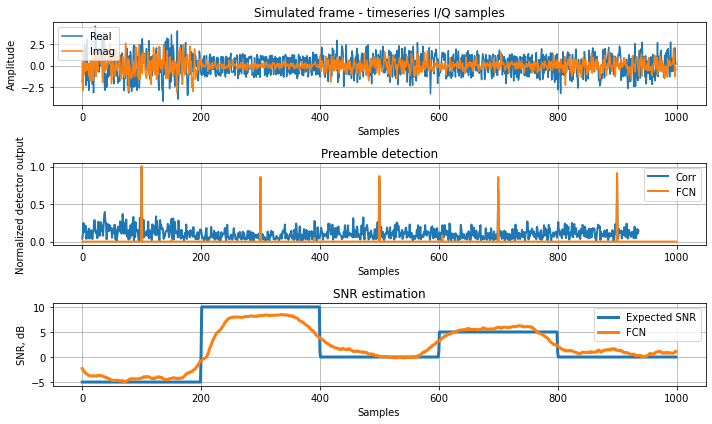

In [38]:
fig, ax = plt.subplots(3, 1, figsize=(10,6))

ax[0].plot(new_frame.squeeze()[0])
ax[0].plot(new_frame.squeeze()[1])
ax[0].grid()
ax[0].set_xlabel('Samples')
ax[0].set_ylabel('Amplitude')
ax[0].legend(['Real', 'Imag'])
ax[0].set_title('Simulated frame - timeseries I/Q samples')

corr_ref = np.abs(np.correlate((new_frame.squeeze()[0] + new_frame.squeeze()[1]*1j), preamble, mode='valid'))
nn_out = nn_output.detach().numpy()

ax[1].plot(corr_ref/np.max(corr_ref), linewidth=2)
ax[1].plot(nn_out/np.max(nn_out), linewidth=2)
ax[1].grid()
ax[1].set_xlabel('Samples')
ax[1].set_ylabel('Normalized detector output')
ax[1].legend(['Corr', 'FCN'])#, loc='upper right')
ax[1].set_title('Preamble detection')

ax[2].plot(box, linewidth=3)
ax[2].plot(cfo_hat.detach().numpy()*10, linewidth=3)
ax[2].grid()
ax[2].set_xlabel('Samples')
ax[2].set_ylabel('SNR, dB')
ax[2].legend(['Expected SNR', 'FCN'])
ax[2].set_title('SNR estimation')

plt.tight_layout()
plt.savefig('figures/full_preamble_detect.png', dpi=300, bbox_inches='tight')

In [47]:
my_frame = create_frame(max_seq[:seq_length], payload=payload, signal_length=signal_length, offset=tau)

if add_phase_offset:
    ph = np.random.randint(-180,high=181)
    my_frame = phase_offset(my_frame, offset=ph)

if carrier_offset is not None:
    offset_sine = np.exp(1j*2*np.pi*(carrier_offset/sample_rate)*np.arange(signal_length))
    my_frame = my_frame*offset_sine

if add_channel:
    gains = 1/np.sqrt(2)*(np.random.normal(0)+1j*np.random.normal(0))
    my_frame = gains*my_frame

# Add noise
my_frame[:201] = awgn(my_frame[:201], -5)
my_frame[200:401] = awgn(my_frame[200:401], 10)
# my_frame[400:601] = awgn(my_frame[400:601], 0)
my_frame[400:600] = awgn(create_frame(max_seq[:seq_length], payload=payload, signal_length=200, offset=tau), 0)
my_frame[600:801] = awgn(my_frame[600:801], 5)
my_frame[800:1000] = awgn(create_frame(max_seq[:seq_length], payload=payload, signal_length=200, offset=tau), 0)#awgn(my_frame[800:1001], 0)

# FCN prediction
new_frame = np.expand_dims(np.vstack((my_frame.real, my_frame.imag)),axis=(0,1))
new_frame = torch.tensor(new_frame).float()
nn_output, cfo_hat = detector(new_frame)

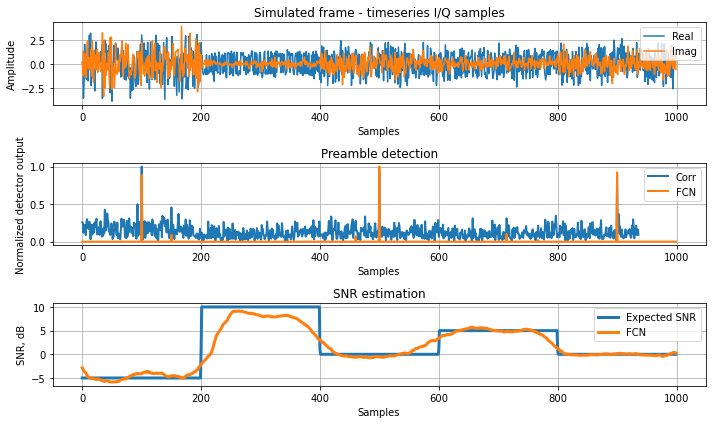

In [49]:
fig, ax = plt.subplots(3, 1, figsize=(10,6))

ax[0].plot(new_frame.squeeze()[0])
ax[0].plot(new_frame.squeeze()[1])
ax[0].grid()
ax[0].set_xlabel('Samples')
ax[0].set_ylabel('Amplitude')
ax[0].legend(['Real', 'Imag'])
ax[0].set_title('Simulated frame - timeseries I/Q samples')

corr_ref = np.abs(np.correlate((new_frame.squeeze()[0] + new_frame.squeeze()[1]*1j), preamble, mode='valid'))
nn_out = nn_output.detach().numpy()

ax[1].plot(corr_ref/np.max(corr_ref), linewidth=2)
ax[1].plot(nn_out/np.max(nn_out), linewidth=2)
ax[1].grid()
ax[1].set_xlabel('Samples')
ax[1].set_ylabel('Normalized detector output')
ax[1].legend(['Corr', 'FCN'])#, loc='upper right')
ax[1].set_title('Preamble detection')

ax[2].plot(box, linewidth=3)
ax[2].plot(cfo_hat.detach().numpy()*10, linewidth=3)
ax[2].grid()
ax[2].set_xlabel('Samples')
ax[2].set_ylabel('SNR, dB')
ax[2].legend(['Expected SNR', 'FCN'])
ax[2].set_title('SNR estimation')

plt.tight_layout()
plt.savefig('figures/sparse_preamble_detect.png', dpi=300, bbox_inches='tight')

In [327]:
my_frame = create_frame(max_seq[:seq_length], payload=payload, signal_length=400, offset=tau)

if add_phase_offset:
    ph = np.random.randint(-180,high=181)
    my_frame = phase_offset(my_frame, offset=ph)

if carrier_offset is not None:
    offset_sine = np.exp(1j*2*np.pi*(carrier_offset/sample_rate)*np.arange(signal_length))
    my_frame = my_frame*offset_sine

if add_channel:
    gains = 1/np.sqrt(2)*(np.random.normal(0)+1j*np.random.normal(0))
    my_frame = gains*my_frame

my_frame = awgn(my_frame, 5)
    
# Add noise
# my_frame[:201] = awgn(my_frame[:201], -5)
# my_frame[200:400] = awgn(create_frame(max_seq[:seq_length], payload=payload, signal_length=200, offset=tau), 10)
# my_frame[400:601] = awgn(my_frame[400:601], 0)
# my_frame[400:600] = awgn(create_frame(max_seq[:seq_length], payload=payload, signal_length=200, offset=tau), 0)
# my_frame[600:800] = awgn(create_frame(max_seq[:seq_length], payload=payload, signal_length=200, offset=tau), 5)
# my_frame[800:1000] = awgn(create_frame(max_seq[:seq_length], payload=payload, signal_length=200, offset=tau), 0)#awgn(my_frame[800:1001], 0)

# FCN prediction
new_frame = np.expand_dims(np.vstack((my_frame.real, my_frame.imag)),axis=(0,1))
new_frame = torch.tensor(new_frame).float()
nn_output, cfo_hat = detector(new_frame)

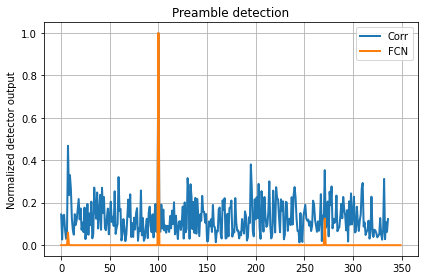

In [328]:
corr_ref = np.abs(np.correlate((new_frame.squeeze()[0] + new_frame.squeeze()[1]*1j), preamble, mode='valid'))
nn_out = nn_output.detach().numpy()

plt.plot(corr_ref[:350]/np.max(corr_ref), linewidth=2)
plt.plot(nn_out[:350]/np.max(nn_out), linewidth=2)
plt.grid()
plt.ylabel('Normalized detector output')
plt.legend(['Corr', 'FCN'])#, loc='upper right')
plt.title('Preamble detection')
plt.tight_layout()

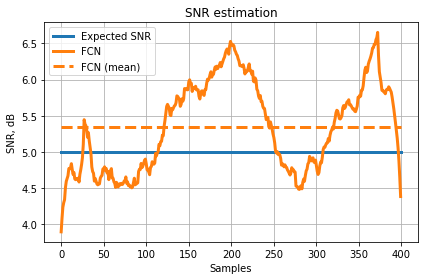

In [330]:
plt.plot(np.ones(400,)*5, linewidth=3)
plt.plot(cfo_hat.detach().numpy()*10, linewidth=3)
plt.plot(np.ones(400,)*np.mean(cfo_hat.detach().numpy()*10), 'C1--', linewidth=3)
plt.grid()
plt.ylabel('SNR, dB'); plt.xlabel('Samples')
plt.legend(['Expected SNR', 'FCN', 'FCN (mean)'])
plt.title('SNR estimation')
plt.tight_layout()
# plt.savefig('figures/fcn_snr_estimation_frame.png', dpi=300, bbox_inches='tight')

In [286]:
snr_range = np.arange(-10,11)

In [304]:
estims = []
baseline_estims = []
num_iter=100

for snr in snr_range:
    running_hat = 0
    running_m2m4 = 0
    
    for i in range(num_iter):
        my_frame = create_frame(max_seq[:seq_length], payload=payload, signal_length=400, offset=tau)
        my_frame = awgn(my_frame, snr)
        
        # FCN prediction
        new_frame = np.expand_dims(np.vstack((my_frame.real, my_frame.imag)),axis=(0,1))
        new_frame = torch.tensor(new_frame).float()
        nn_output, cfo_hat = detector(new_frame)
        running_hat += cfo_hat/num_iter
    
        # m2m4 prediction
        m2 = (np.sum(np.abs(my_frame**2)))/len(my_frame)
        m4 = (np.sum(np.abs(my_frame**4)))/len(my_frame)

        running_m2m4 += np.sqrt(np.abs(2*(m2**2)-m4))/(m2 - np.sqrt(np.abs(2*(m2**2)-m4)))/num_iter
    
    baseline_estims.append(10*np.log10(running_m2m4))
    
    estims.append(np.mean(running_hat.cpu().detach().numpy())*10)

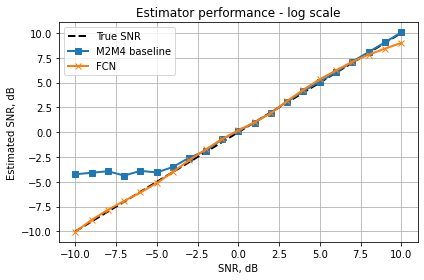

In [346]:
plt.plot(snr_range, snr_range, 'k--', linewidth=2)
plt.plot(snr_range, baseline_estims, 's-', linewidth=2)
plt.plot(snr_range, estims, 'x-', linewidth=2)
plt.grid()
plt.legend(['True SNR', 'M2M4 baseline', 'FCN'])
plt.xlabel('SNR, dB'); plt.ylabel('Estimated SNR, dB')
plt.title('Estimator performance - log scale')
plt.tight_layout()
# plt.savefig('figures/fcn_snr_estimation_db_scale.png', dpi=300, bbox_inches='tight')

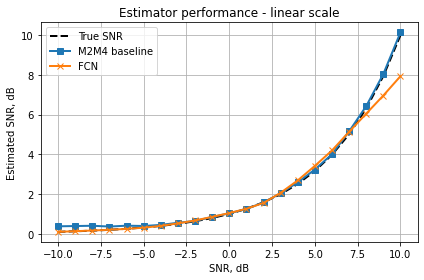

In [347]:
plt.plot(snr_range, 10**(snr_range/10), 'k--', linewidth=2)
plt.plot(snr_range, 10**(np.array(baseline_estims)/10), 's-', linewidth=2)
plt.plot(snr_range, 10**(np.array(estims)/10), 'x-', linewidth=2)
plt.grid()
plt.legend(['True SNR', 'M2M4 baseline', 'FCN'])
plt.xlabel('SNR, dB'); plt.ylabel('Estimated SNR, dB')
plt.title('Estimator performance - linear scale')
plt.tight_layout()
# plt.savefig('figures/fcn_snr_estimation_linear_scale.png', dpi=300, bbox_inches='tight')

In [348]:
all_loss_ratios = []
for i in range(1,10):
    models = []

    fs_weight = round(i*0.1, 1)
    snr_weight = round(1 - i*0.1, 1)
    
    loss_ratios = (fs_weight, snr_weight)
    
    all_loss_ratios.append(loss_ratios)
all_loss_ratios

[(0.1, 0.9),
 (0.2, 0.8),
 (0.3, 0.7),
 (0.4, 0.6),
 (0.5, 0.5),
 (0.6, 0.4),
 (0.7, 0.3),
 (0.8, 0.2),
 (0.9, 0.1)]

8
8
4
7
7
7


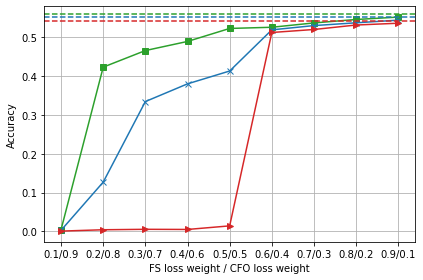

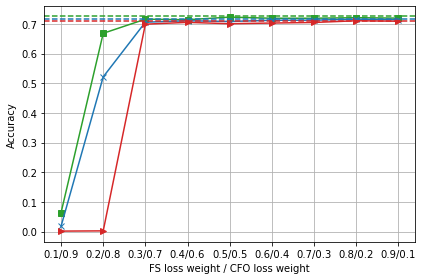

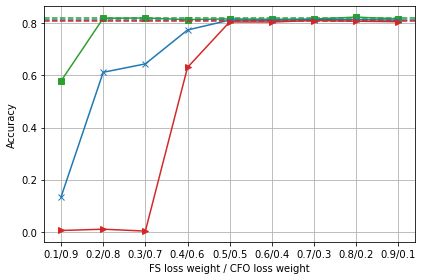

In [357]:
for seq_length in seq_lengths:
    bests, means, worsts = [], [], []

    for loss_ratios in all_loss_ratios:
        best, mean, worst = calc_stats(f'results/continuous/mtl_fs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{num_examples}_{seq_length}.pt')
        bests.append(best)
        means.append(mean)
        worsts.append(worst)
    print(np.argmax(bests))
    print(np.argmax(means))

    baseline_best, baseline_mean, baseline_worst = \
    calc_stats(path=f"results/continuous/fs_{num_examples}_{seq_length}.pt")

    legend = [f'{loss_ratios[0]}/{loss_ratios[1]}' for loss_ratios in all_loss_ratios]

    plt.figure()
    plt.plot(np.array(bests), '-s', color='C2')
    plt.plot(np.array(means), '-x', color='C0')
    plt.plot(np.array(worsts), '->', color='C3')
    plt.axhline(y=baseline_best, color='C2', linestyle='--')
    plt.axhline(y=baseline_mean, color='C0', linestyle='--')
    plt.axhline(y=baseline_worst, color='C3', linestyle='--')
    # plt.legend(['Best (MTL)', 'Mean (MTL)', 'Worst (MTL)', 'Best (baseline)', 'Mean (baseline)', 'Worst (baseline)'], loc='lower right')
    plt.xticks(np.arange(len(all_loss_ratios)), legend)
    plt.xlabel('FS loss weight / CFO loss weight'); plt.ylabel('Accuracy')
    plt.grid()
#     plt.ylim([0.5, 0.7])
    plt.tight_layout()

In [4]:
# make one frame of data with preamble attached with random time offset
def create_frame(preamble_seq, payload=128, signal_length=200, offset=40):
    waveform = np.random.randint(0,2,signal_length)
    waveform[offset:offset+len(preamble_seq)] = preamble_seq
    waveform = np.where(waveform < 1, -1+0j, 1+0j)
    
    return waveform

In [5]:
frame = create_frame(max_seq, signal_length=200, offset=75)

In [6]:
noisy_frame = awgn(frame, 15)

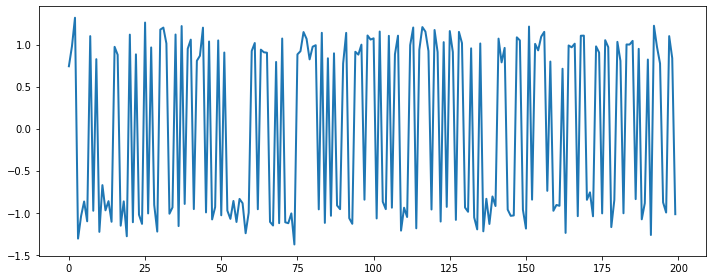

In [7]:
plt.figure(figsize=(10,4))
plt.plot(noisy_frame.real, linewidth=2)
plt.tight_layout()
# plt.savefig('figures/fs_training_example.svg', dpi=300, bbox_inches='tight')

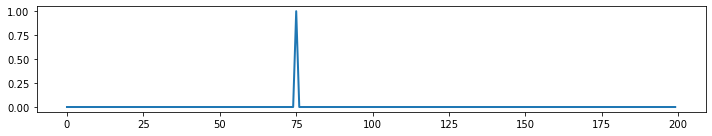

In [25]:
plt.figure(figsize=(10,2))
fs_label = np.zeros(200)
fs_label[75] = 1
plt.plot(fs_label, linewidth=2)
# plt.grid()
plt.tight_layout()
# plt.savefig('figures/fs_training_example_fs_label.svg', dpi=300, bbox_inches='tight')

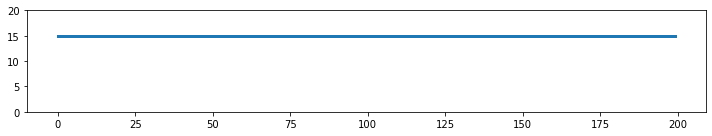

In [26]:
plt.figure(figsize=(10,2))
snr_label = np.ones(200)*15
plt.plot(snr_label, linewidth=3)
plt.ylim([0,20])
# plt.grid()
plt.tight_layout()
# plt.savefig('figures/fs_training_example_snr_label.svg', dpi=300, bbox_inches='tight')